<a href="https://colab.research.google.com/github/JoeArmel/JoeArmel/blob/main/0606Final_SVR_Gaz_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MODELE PREDICTIF CONSOMMATION GAZ**


---

##**1. Installation du module de construction des fichiers *pmml*.**

In [ ]:
!pip install sklearn2pmml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 4.5 MB/s 
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.83.0-py3-none-any.whl size=6267699 sha256=9b3fb94801d4dbd7d24403525070f532beaaddf1ffc5aa006ce11efc5af1cff8
  Stored in directory: /root/.cache/pip/wheels/97/6f/6e/711f820c572619b94c51830a0ca64efa699aa878548acfb13f
Successfully built sklearn2pmml


In [ ]:
# Connexion de Colab à Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##**2. Importation des modules nécessaires à l'exploitation des données**

In [ ]:
import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import make_pmml_pipeline, sklearn2pmml

import numpy as np
import pandas as pd
from sklearn_pandas import DataFrameMapper

from sklearn import model_selection, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn import svm 

import matplotlib.pyplot as plt
import seaborn as sns

###**Chargement des données**

In [ ]:
# Importation des données et chargement dans un Dataframe
gaz = pd.read_csv('/content/gdrive/MyDrive/PFE_Models/DonnéesGazPrixConso_2022.csv', sep=";")

#Affichage des dix premières lignes de données
gaz.head(10)

Code_Region  Année  Mois  Nbre Jours fériés  Vitesse Moyenne Vent (m/s)  \
0           84   2013     1                  1                        3.15   
1           84   2013     2                  0                        3.58   
2           84   2013     3                  0                        3.31   
3           84   2013     4                  1                        3.09   
4           84   2013     5                  4                        2.82   
5           84   2013     6                  0                        3.26   
6           84   2013     7                  1                        2.65   
7           84   2013     8                  1                        2.75   
8           84   2013     9                  0                        2.60   
9           84   2013    10                  0                        3.20   

   Taux Moyen Humidité  Hauteur Moyenne Neige (m)  \
0                81.05                        0.0   
1                76.59                        0.0   
2                72.82                        0.0   
3                69.91                        0.0   
4                74.21                        0.0   
5                65.35                        0.0   
6                63.13                        0.0   
7                64.30                        0.0   
8                69.52                        0.0   
9                76.97                        0.0   

   Moyenne_Temperature min (12h)  Min_Temperature min  \
0                           0.08                  0.0   
1                          -0.30                  0.0   
2                           0.70                  0.0   
3                           1.55                  0.0   
4                           2.07                  0.0   
5                           3.25                  0.0   
6                           4.21                  0.0   
7                           3.78                  0.0   
8                           3.12                  0.0   
9                           2.85                  0.0   

   Moyenne_Temperature min (24h)  Max_Temperature min  \
0                            0.0                  0.0   
1                            0.0                  0.0   
2                            0.0                  0.0   
3                            0.0                  0.0   
4                            0.0                  0.0   
5                            0.0                  0.0   
6                            0.0                  0.0   
7                            0.0                  0.0   
8                            0.0                  0.0   
9                            0.0                  0.0   

   Temperature Moyenne (°C)  Min_Temperature max  \
0                      2.78                  0.0   
1                      1.29                  0.0   
2                      6.21                  0.0   
3                     10.25                  0.0   
4                     11.47                  0.0   
5                     17.28                  0.0   
6                     22.14                  0.0   
7                     20.05                  0.0   
8                     16.95                  0.0   
9                     14.36                  0.0   

   Moyenne_Temperature max (12h)  Max_Temperature max  \
0                           1.22                  0.0   
1                           0.92                  0.0   
2                           2.31                  0.0   
3                           3.42                  0.0   
4                           3.69                  0.0   
5                           5.30                  0.0   
6                           6.77                  0.0   
7                           6.18                  0.0   
8                           5.23                  0.0   
9                           4.22                  0.0   

   Moyenne_Temperature max (24h)  Temperature du sol  Précipitation (mm)  \
0                          

##**3. Analyse des corrélations**

###**3.1 Analyse des distributions croisées de variables**

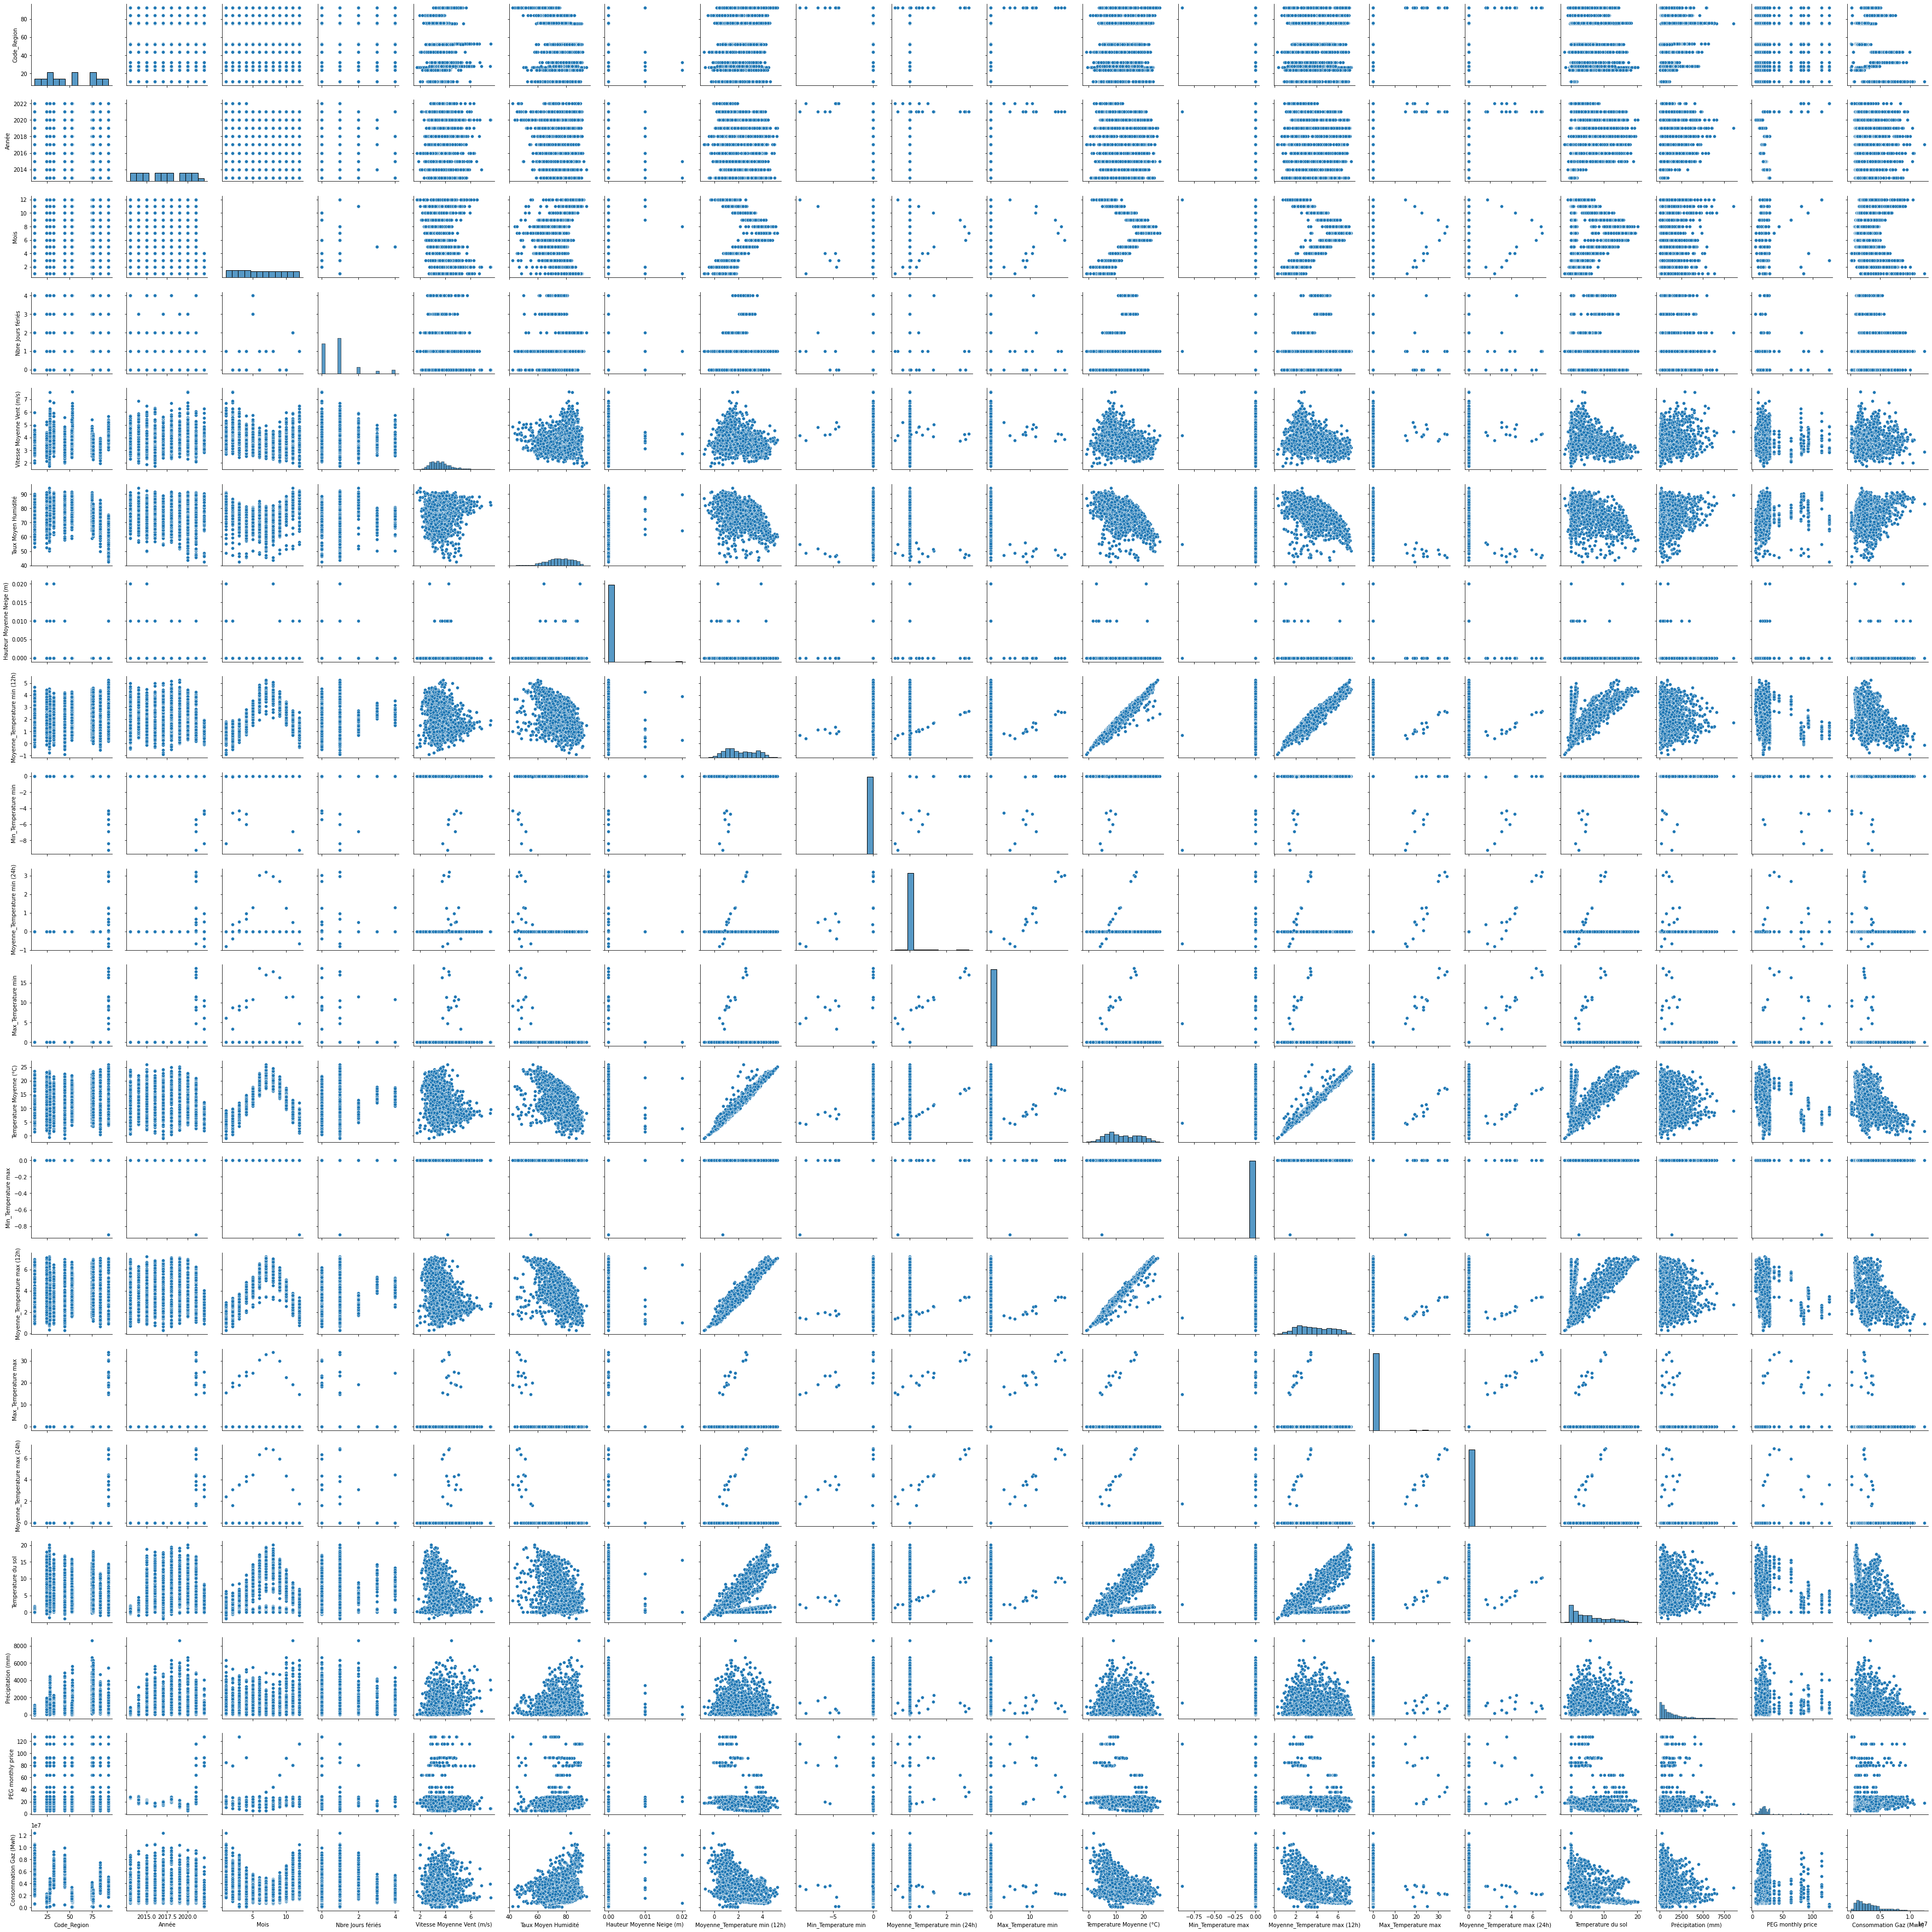

In [ ]:
sns.pairplot(gaz);

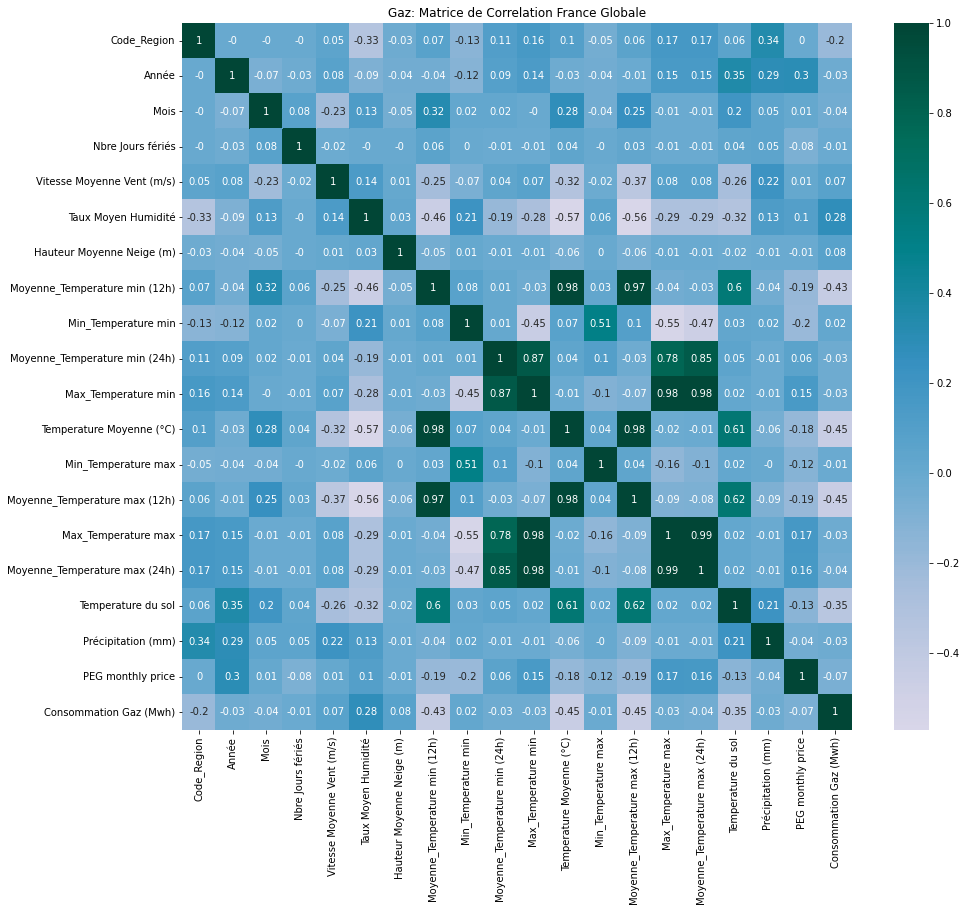

In [ ]:
# Affichage de la matrice de corrélation globale

fig, ax = plt.subplots(figsize = (15, 13))
ax = sns.heatmap(gaz.corr().round(2), annot=True, cmap = 'PuBuGn', center=0) 
plt.title('Gaz: Matrice de Correlation France Globale')
fig.savefig('gdrive/MyDrive/PFE_Models/GazGlobal_France_Correlation_Matrix.png')
plt.show();

La matrice de corrélation ne permet pas de déceller des variables qui se démarquent significativement par leur impact (positif ou négatif) sur la consommation de gaz.

Afin d'affiner notre analyse, nous effectuerons un filtre sur chaque région pour identifier si elles existent, les variables ayant un grand impact sur la consommation.

###**3.2 Analyses régionales des corrélations**

In [ ]:
#Récupération du code de chaque région
code = gaz["Code_Region"].unique()

##code = array([84, 27, 53, 24, 44, 32, 11, 28, 75, 76, 52, 93])

# Sélection des données correpondantes à chaque région présente dans mon dataset gaz et stockage dans des variables.
#gaz_ARA = gaz.loc[gaz['Code_Region']==code[0]]      #Auvergne Rhone Alpe
#gaz_BFC = gaz.loc[gaz['Code_Region']==code[1]]      #Bourgogne Franche Comte
#gaz_BRE = gaz.loc[gaz['Code_Region']==code[2]]      #Bretagne
#gaz_CVL = gaz.loc[gaz['Code_Region']==code[3]]      #Centre Val de Loire
#gaz_GDE = gaz.loc[gaz['Code_Region']==code[4]]      #Grand Est
#gaz_HDF = gaz.loc[gaz['Code_Region']==code[5]]      #Hauts de France
#gaz_IDF = gaz.loc[gaz['Code_Region']==code[6]]      #Ile de France
#gaz_NOR = gaz.loc[gaz['Code_Region']==code[7]]      #Normandie
#gaz_NAQ = gaz.loc[gaz['Code_Region']==code[8]]      #Nouvelle Aquitaine
#gaz_OCC = gaz.loc[gaz['Code_Region']==code[9]]      #Occitanie
#gaz_PDL = gaz.loc[gaz['Code_Region']==code[10]]     #Pays de la Loire
#gaz_PACA = gaz.loc[gaz['Code_Region']==code[11]]    #Provence Alpes Côte d'Azur

####**Affichage de la matrice de distribution croisée des variables pour la région Auvergne Rhône Alpes**

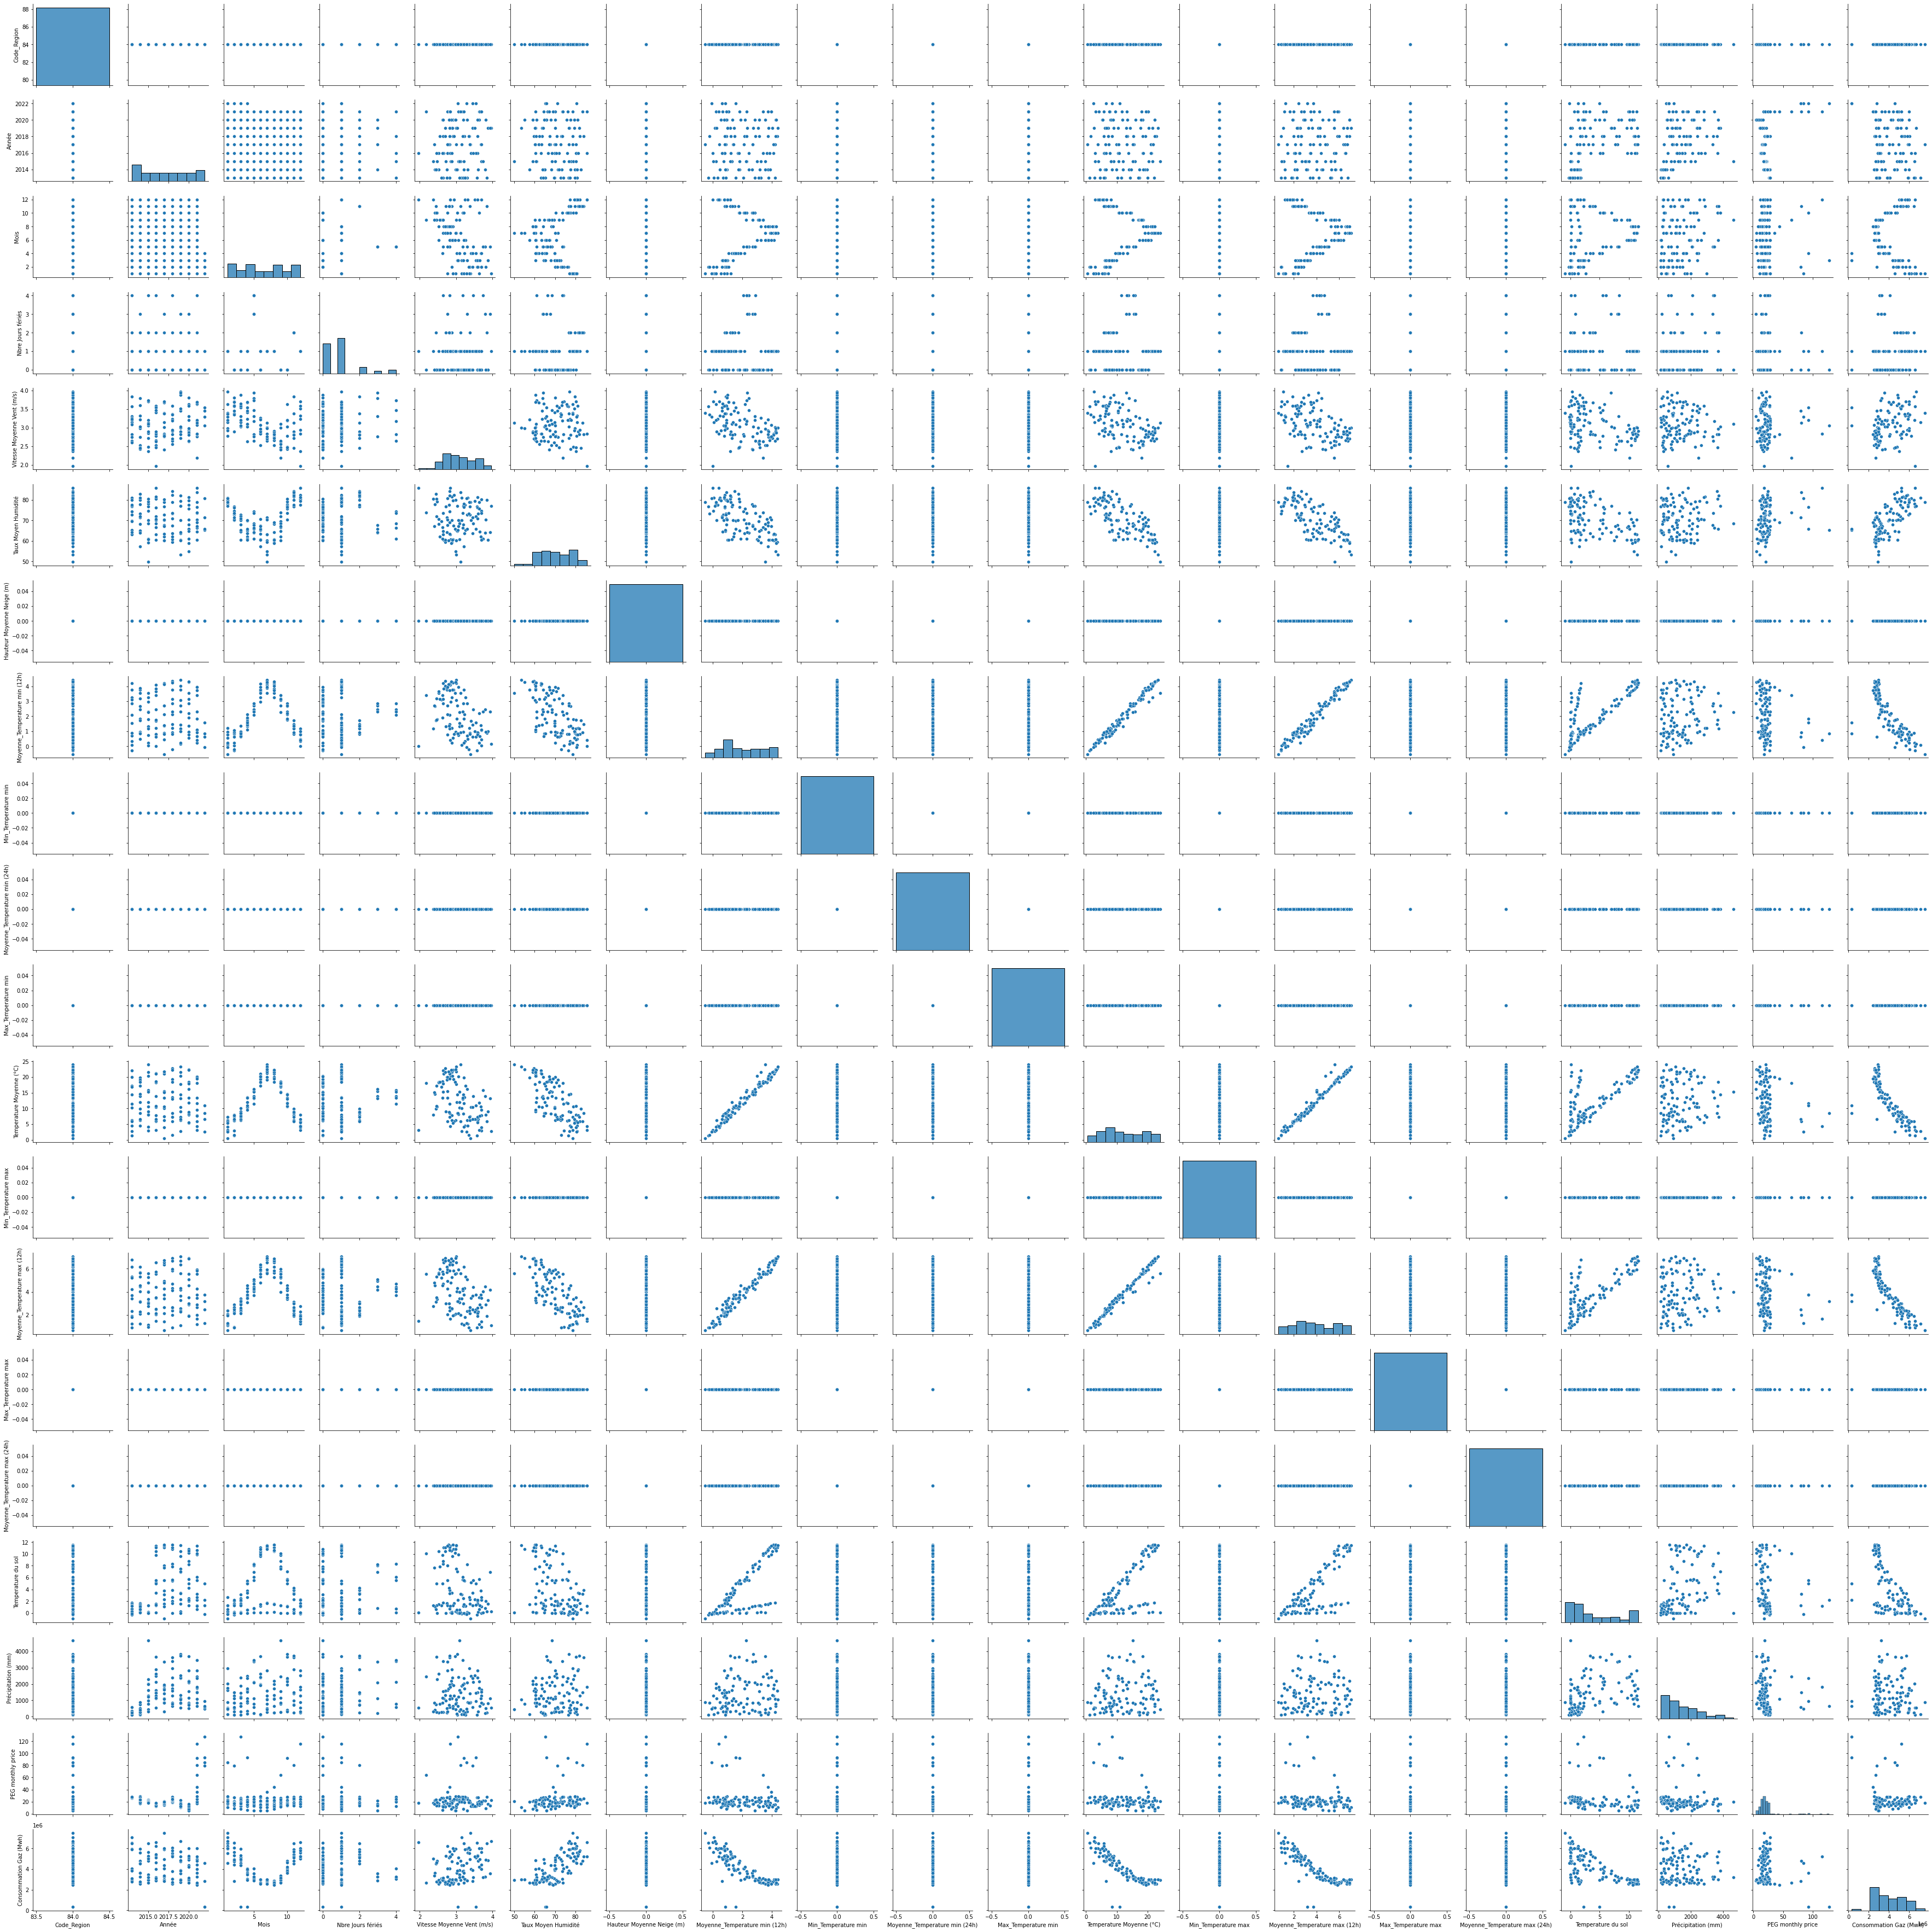

In [ ]:
sns.pairplot(gaz.loc[gaz['Code_Region']==code[0]]);

On peut noter en analysant la **dernière ligne** de cette matrice que, des relations assez claires semblent être mises en évidence entre la consommation de gaz et les certaines variables dont le mois et certaines températures.

Pour y voir un peu plus clair, nous allons repésenter **la matrice de corrélation** associée à chaque région.

####**Affichage des matrices de corrélation par région**

In [ ]:
# Liste des régions
region = ['Auvergne-Rhône-Alpe' ,'Bourgogne-Franche-Comté', 'Bretagne', 'Centre Val de Loire',
          'Grand Est', 'Hauts-De-France', 'Ile-De-France', 'Normandie','Nouvelle Aquitaine', 
          'Occitanie', 'Pays de la Loire', 'Provence Alpes Côte d\'Azur']

# Liste des noms courts des régions
shortRegion = ['AuvergneRA' ,'BourgogneFC', 'Bretagne', 'CentreVL', 'GrandEst', 'HautsDF', 'IleDF', 'Normandie', 'NouvelleAq', 'Occitanie', 'PaysLoire', 'PACA']

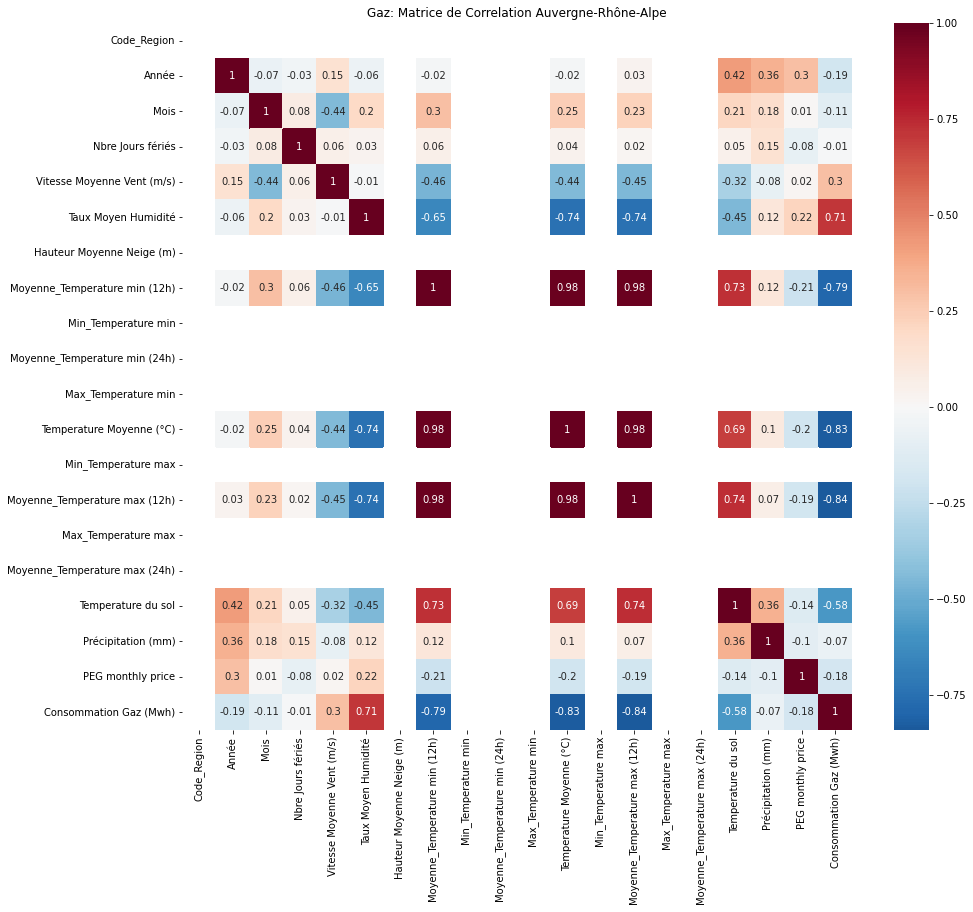

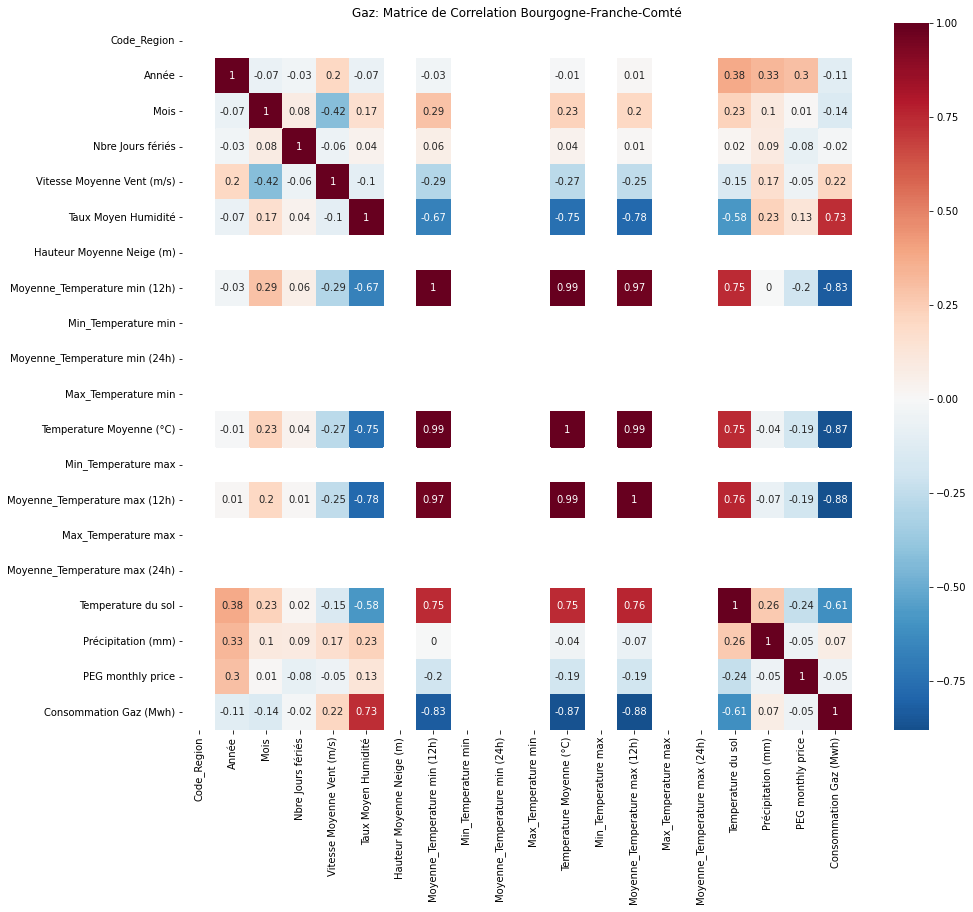

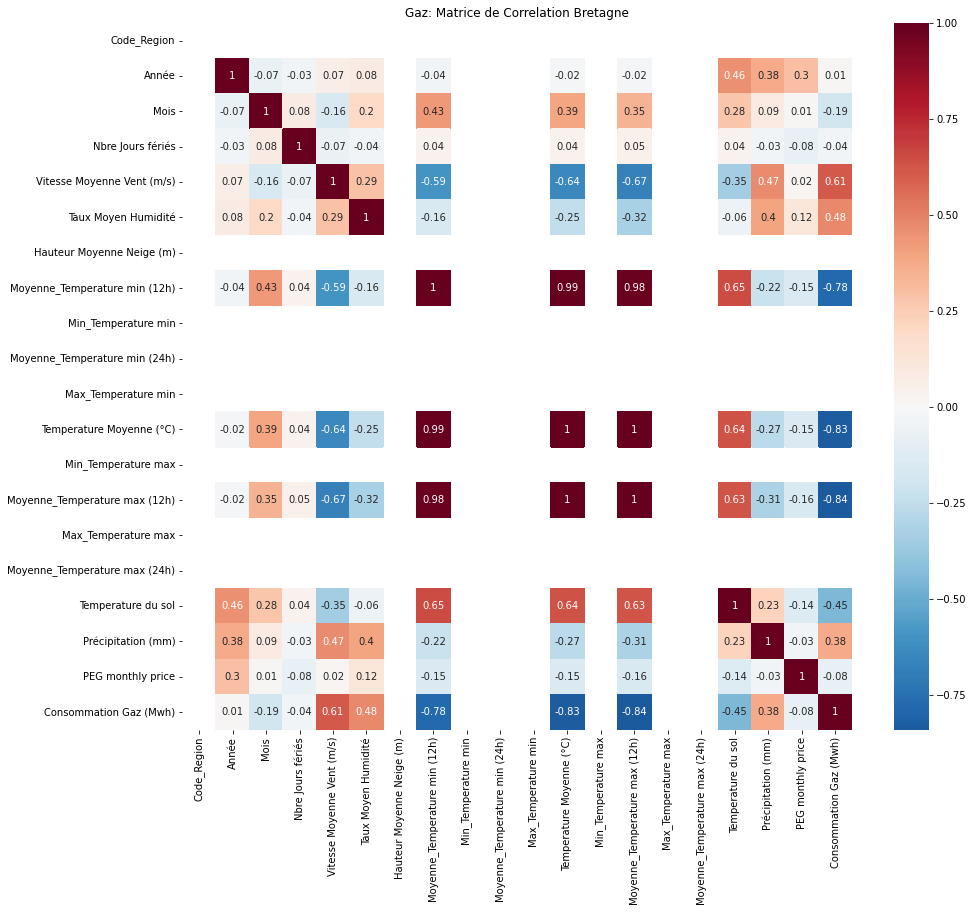

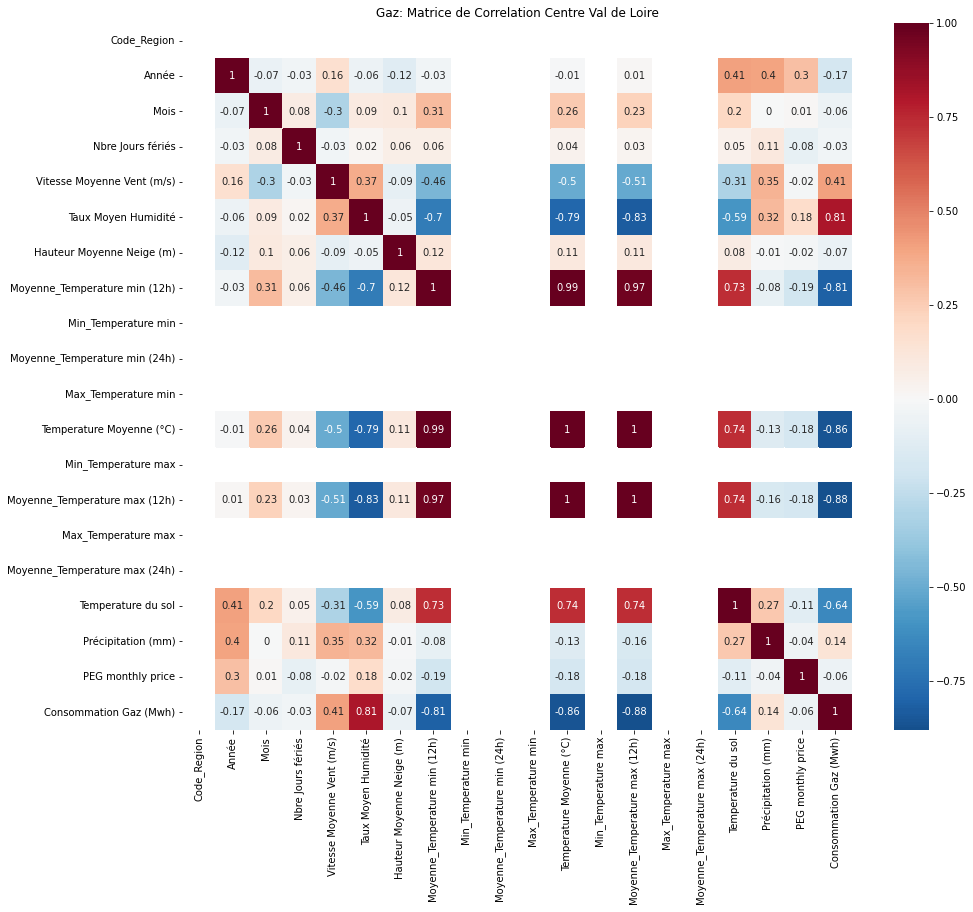

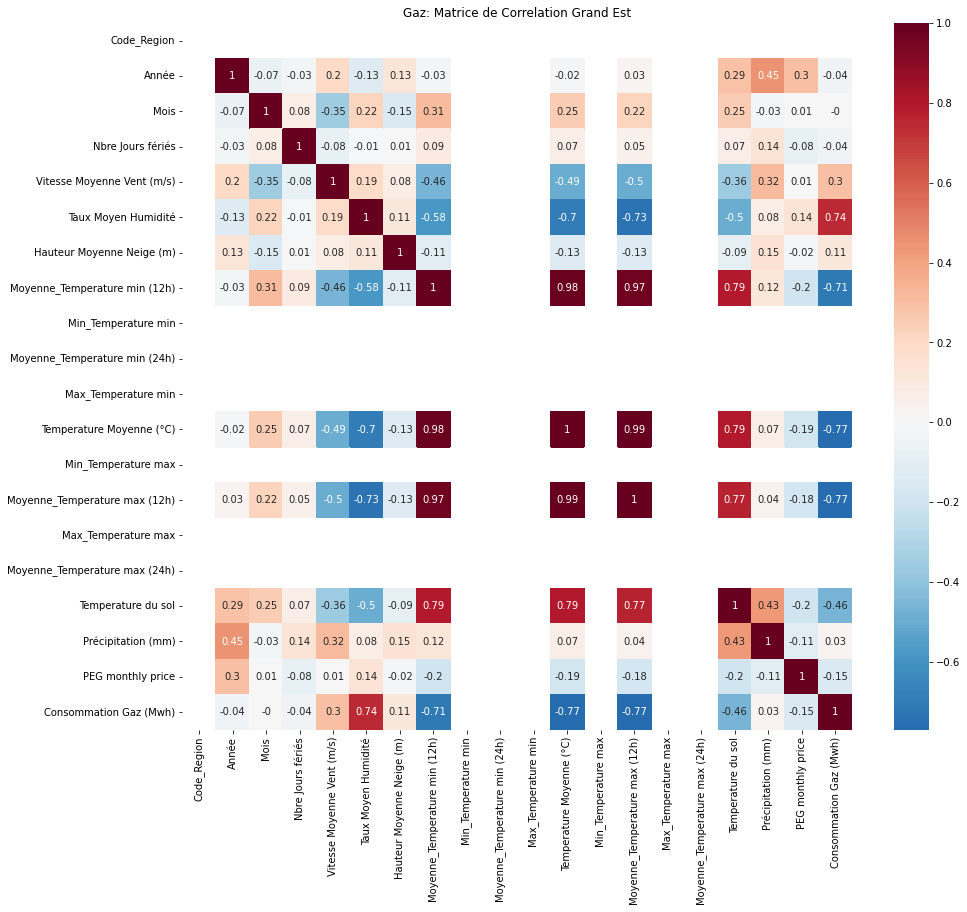

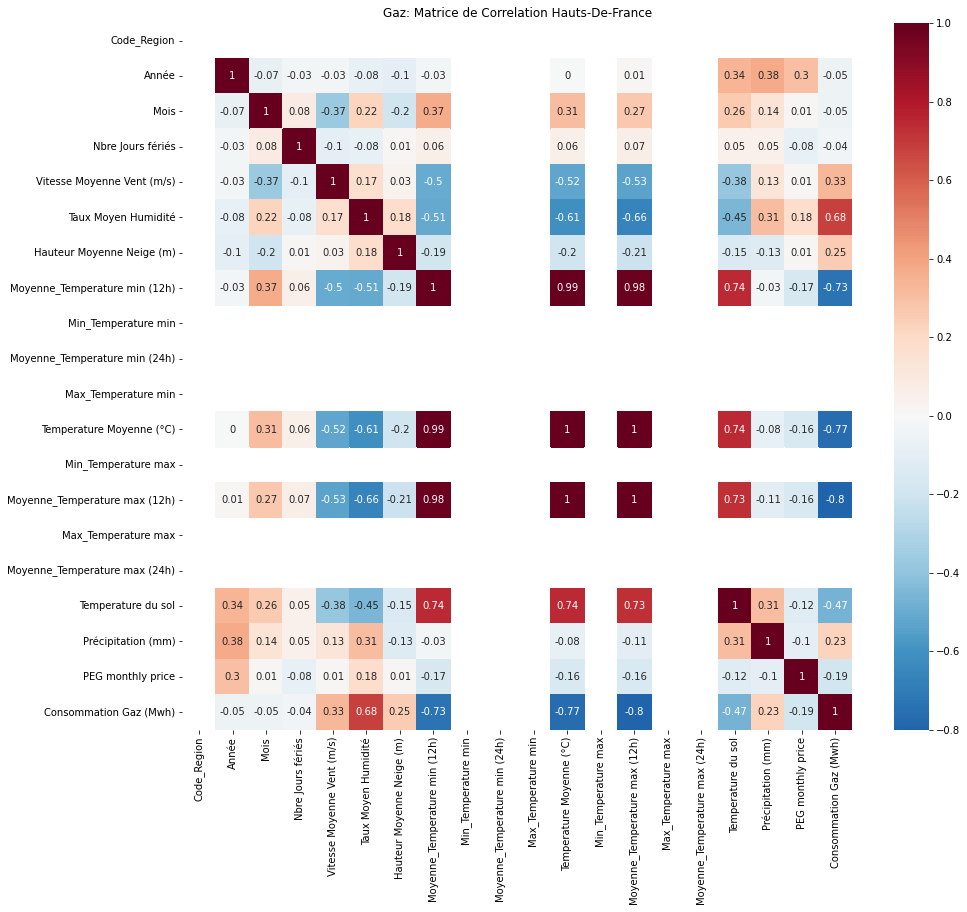

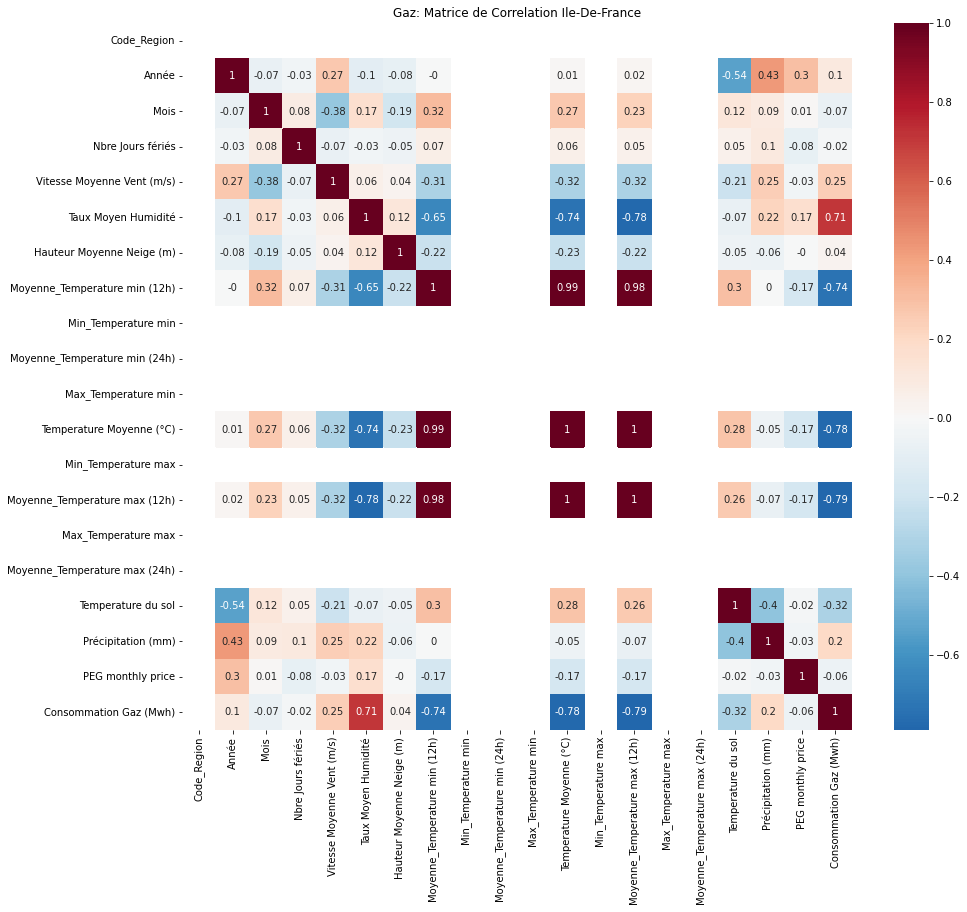

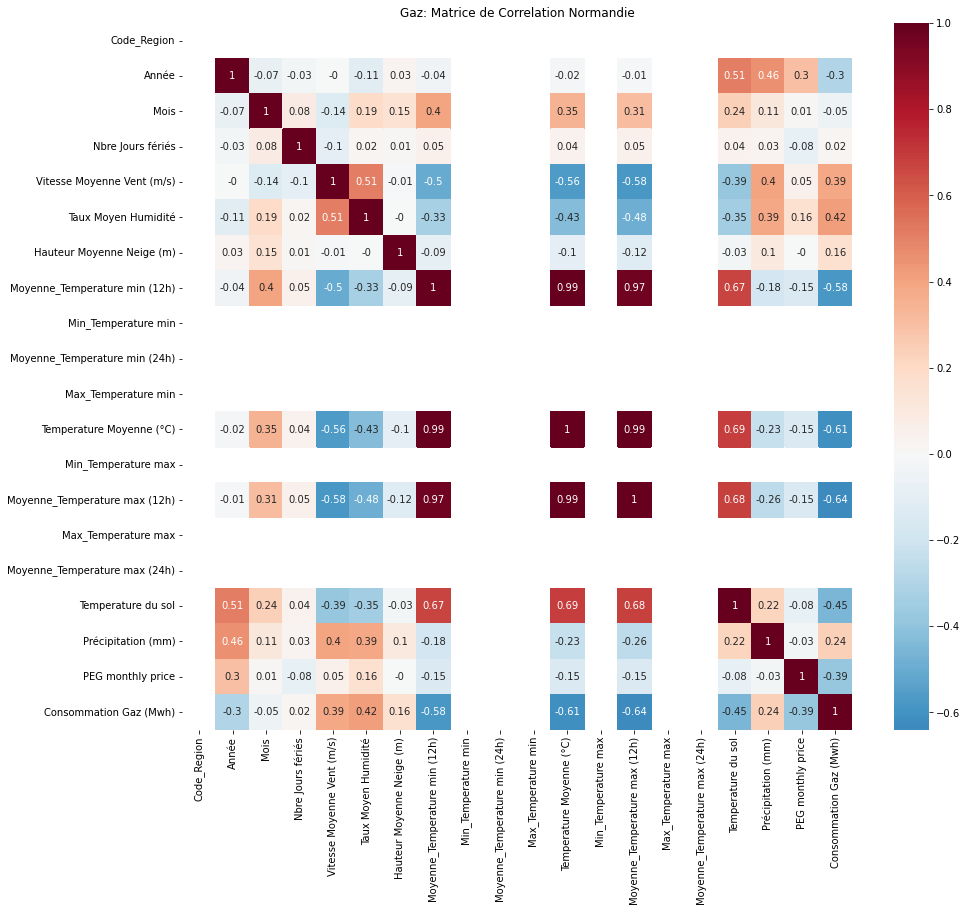

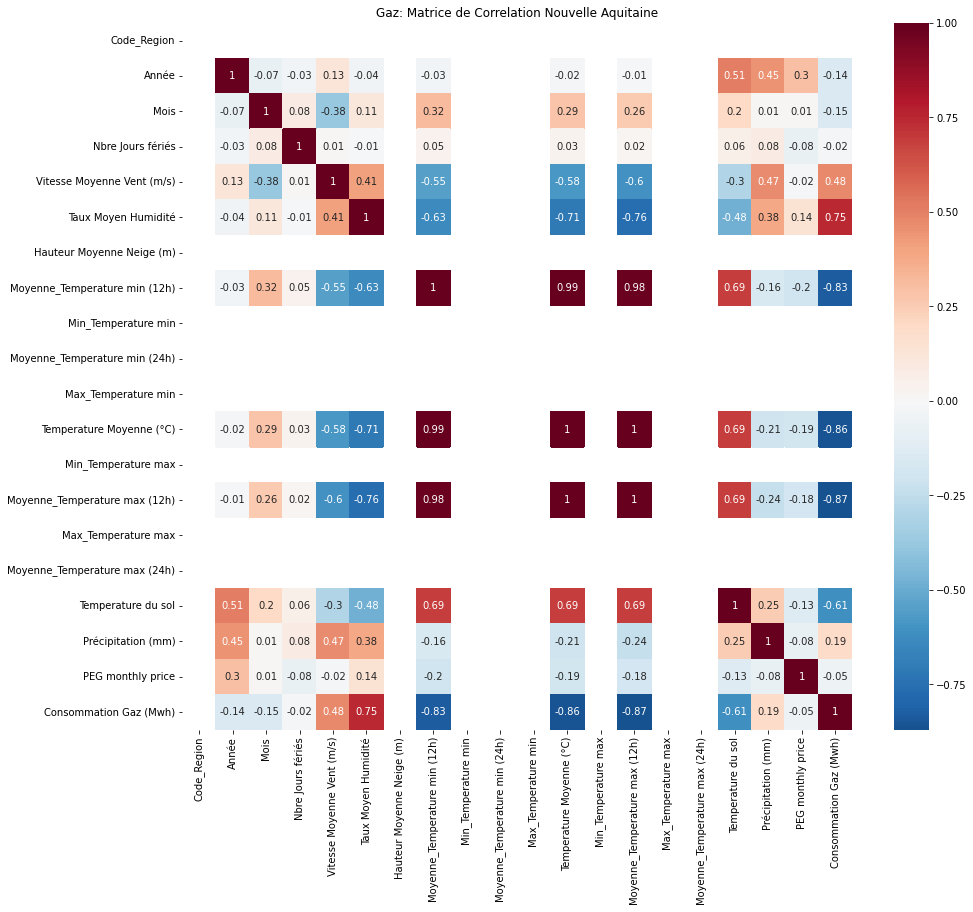

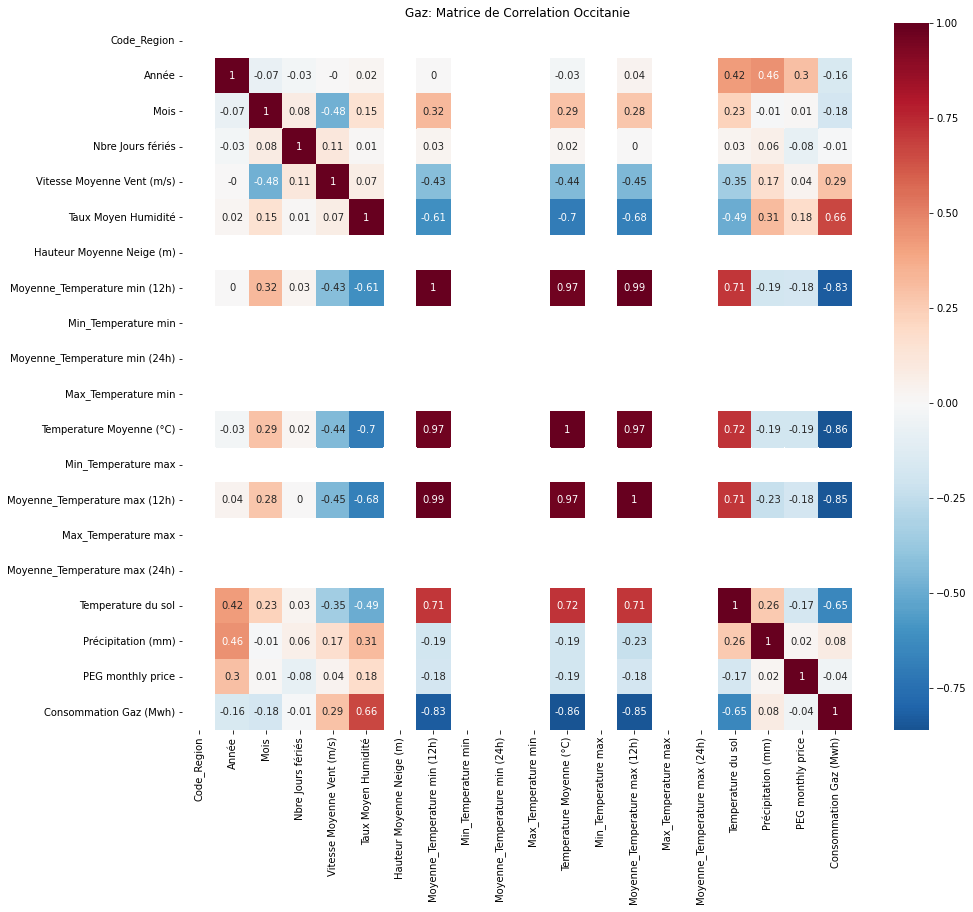

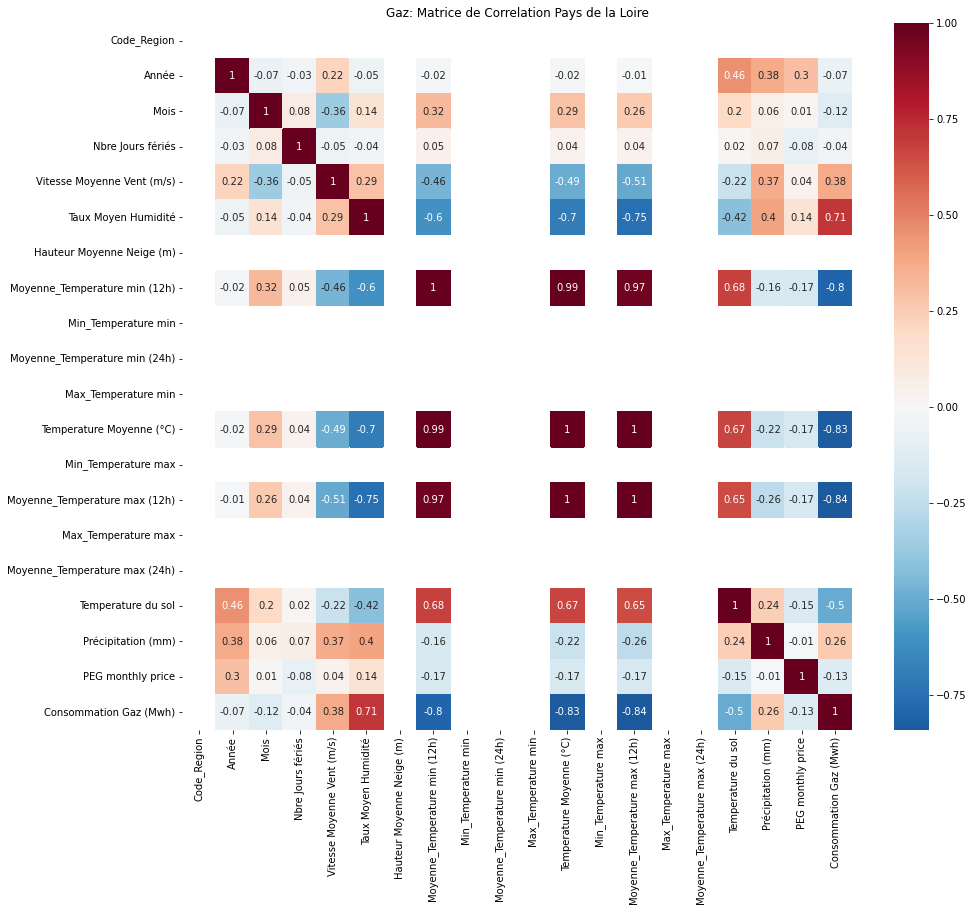

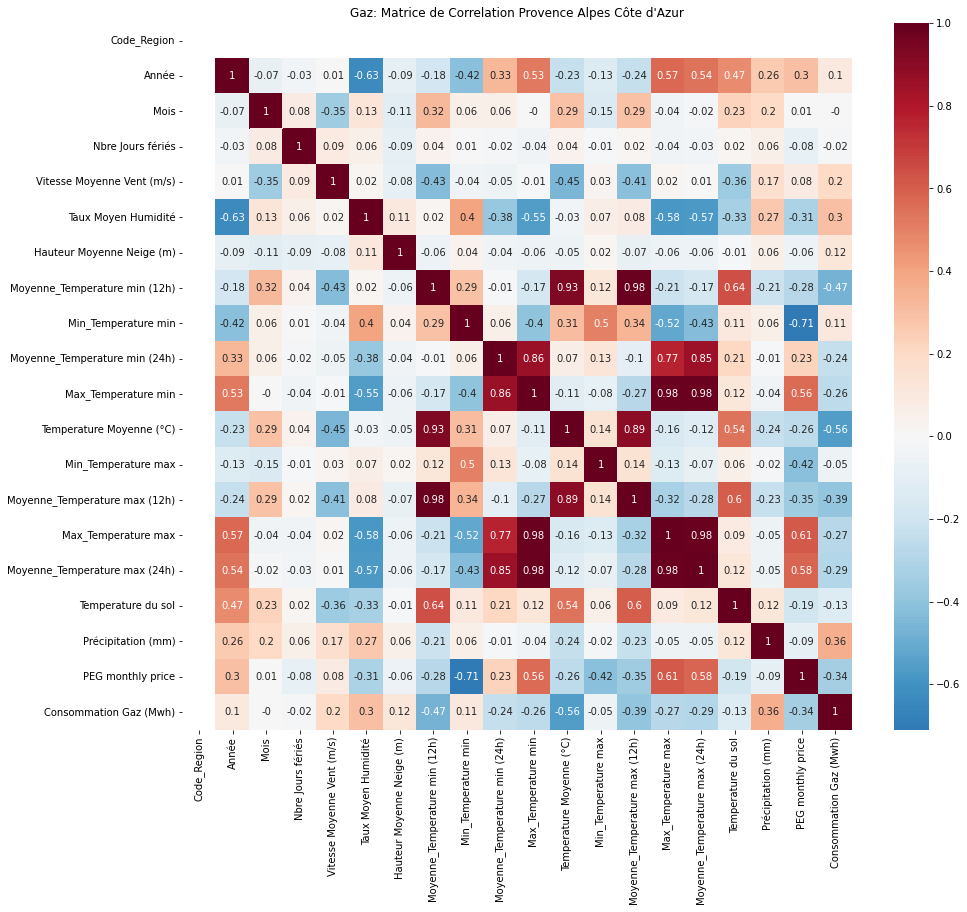

In [ ]:
# Affichage et sauvegarde des matrices de corrélation régionnales
      # Ce bout de code exécute une boucle qui construit un titre, un chemin de sauvegarde, un jeu de donnée correspondant à chaque région
      # puis, génère la matrice de corrélation associé à chaque région
      # et enfin, affiche et stocke le graphique généré à l'emplacement indiqué.

     
for i in range(len(code)):

  df_region = gaz.loc[gaz['Code_Region']==code[i]]                                                          # Données de la région
  title = 'Gaz: Matrice de Correlation '+ region[i]                                                         # Titre
  path = 'gdrive/MyDrive/PFE_Models/gaz_'+ shortRegion[i] + '_Correlation_Matrix.png'                       # Chemin de sauvegarde

  fig, ax = plt.subplots(figsize = (15, 13))                                                                 # Construction de le figure
  ax = sns.heatmap(df_region.corr().round(2), annot=True, cmap = 'RdBu_r', center=0)                         # Matrice de corrélation régionale
  plt.title(title)                                                                                           # Ajout du titre au graphique
  fig.savefig(path)                                                                                          # Sauvegarde du graphique
  plt.show();

On peut noter que la tendance se confirme et qu'au final très peu de variables on une influence forte sur la consommation de gaz. Ce sont globalement, la région à travers "***Code_Région***", le ***mois***, le ***Taux d'humidité***, la ***moyenne des températures min (12h)***, la ***température moyenne***, la ***moyenne des températures max (12h)***, la ***température du sol***. 

Pour la construction de notre modèle et compte tenu des contraintes telles que : 
> 1. nombre maximal de variables fixé à 7 dans l'environnement de production;
> 2. utilisation d'au moins une variable financière (cours du gaz) comme variable explicative;

nous avons fait le choix de remplacer la variable ***moyenne des températures min (12h)*** par ***PEG Monthly Price*** qui indique le cours moyen mensuel du gaz sur la place boursière PEG.


Ce sont donc ces variables que nous utiliserons pour construire notre modèle de prédiction.

##**4. Construction du modèle**



> Le modèle que nous construisons est un modèle de type pipeline qui entrainera sur les données, plusieurs modèles **SVR** de noyau **'rbf'** et procèdra, par une validation croisée de ceux-ci grâce à une grille de recherche, à la sélection du modèle le plus performant.


In [ ]:
# Identification de la variable cible à prédire (target) et des variables explicatives les plus correlées.
target = gaz["Consommation Gaz (Mwh)"]
data = gaz.drop(["Consommation Gaz (Mwh)", "Année", "Nbre Jours fériés",
                   "Hauteur Moyenne Neige (m)", "Vitesse Moyenne Vent (m/s)", "Min_Temperature min",
                   "Moyenne_Temperature min (12h)", "Moyenne_Temperature min (24h)", "Max_Temperature min",
                   "Min_Temperature max", "Max_Temperature max", "Moyenne_Temperature max (24h)", "Précipitation (mm)"], axis = 1)


#Séparation des données en jeux d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2,  random_state=101)


# Construction du modèle

## Le mapper indique les différentes opérations qui seront appliquées à chacune des colonnes du jeux de données dans le modèle avant entrainement.

mapper2 = DataFrameMapper([
    (["Code_Region", "Mois"], None),
    (["Taux Moyen Humidité", "Temperature Moyenne (°C)", "Moyenne_Temperature max (12h)", "Temperature du sol", "PEG monthly price"], MinMaxScaler())
    ])

# Modèle de base
rbf2 = svm.SVR(kernel='rbf', gamma=0.02, epsilon=0.1)


pipeline = PMMLPipeline([
    ("mapping", mapper2),
    ("Regressor", rbf2)
])


params = {
    "Regressor__C": [0.001, 0.01, 0.15, 0.1, 0.2, 1, 10, 100, 1000, 10000, 1e5, 2e6, 3e6 ,1e6, 1e7],
    "Regressor__gamma": [0.00001, 0.0001, 0.001, 0.1, 0.2, 0.5]
}


# Grille de recherche du meilleur modèle par validation croisée
pmodel = GridSearchCV(estimator = pipeline, param_grid = params, cv=9)



# Entrainement du modèle
pmodel.fit(x_train, y_train)

GridSearchCV(cv=9,
             estimator=PMMLPipeline(steps=[('mapping', DataFrameMapper(features=[(['Code_Region', 'Mois'], None), (['Taux Moyen Humidité', 'Temperature Moyenne (°C)', 'Moyenne_Temperature max (12h)', 'Temperature du sol', 'PEG monthly price'], MinMaxScaler())])), ('Regressor', SVR(gamma=0.02))]),
             param_grid={'Regressor__C': [0.001, 0.01, 0.15, 0.1, 0.2, 1, 10,
                                          100, 1000, 10000, 100000.0, 2000000.0,
                                          3000000.0, 1000000.0, 10000000.0],
                         'Regressor__gamma': [1e-05, 0.0001, 0.001, 0.1, 0.2,
                                              0.5]})

###**Identification du meillleur modèle**

In [ ]:
#Récupération du meilleur modèle obtenu après validation croisée et affichage des paramètres optimaux de ce modèle.
best_pipeline = pmodel.best_estimator_

best_pipeline

PMMLPipeline(steps=[('mapping', DataFrameMapper(features=[(['Code_Region', 'Mois'], None),
                          (['Taux Moyen Humidité', 'Temperature Moyenne (°C)',
                            'Moyenne_Temperature max (12h)',
                            'Temperature du sol', 'PEG monthly price'],
                           MinMaxScaler())])),
       ('Regressor', SVR(C=10000000.0, gamma=0.5))])

In [ ]:
# Calcul et Affiche du score de prédiction sur le jeu de données de validation
best_pipeline.score(x_test, y_test)

0.9355519232711024

###**Calcul des préditions, des métriques et sauvegarde du modèle au format *.pmml***

In [ ]:
# Prédiction du modèle. Cette prédiction est tockée dans une variable pour une utilisation ultérieure. 
y_pipe = best_pipeline.predict(x_test)

# Calcul des métriques

RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_pipe)),'.3f'))
MSE = mean_squared_error(y_test, y_pipe)
r2 = r2_score(y_test, y_pipe)

print("Gaz_Root Mean Squared Error : ", RMSE)
print("Gaz_Mean Squared Error : ", MSE)
print("Gaz_R2 : ", r2)

Root Mean Squared Error :  532481.883
Mean Squared Error :  283536956094.32434
R2 :  0.9355519232711024


In [ ]:
# Conversion et sauvegarde du modèle entraîné au format pmml. Le fichier sera exporté dans l'outil IPM pour y être déployé et mis en production.
sklearn2pmml(best_pipeline, "/content/gdrive/MyDrive/PFE_Models/06062022GazSVR_model.pmml", with_repr = True)

##**5. Comparaisons prédictions vs données réelles**

In [ ]:
# Comparaison des valeurs prédites et des valeurs réelles
compare = pd.DataFrame({'Consommation' : y_test, 'Model_prediction':y_pipe}, index = y_test.index).sort_values(by=['Consommation'],
                                                                                                               ascending=False)
                      
# Affichage des 10 premières valeurs
compare.head(10)

Consommation  Model_prediction
720      12438587      1.002169e+07
708      10613854      9.728965e+06
768       9533929      9.821429e+06
779       9013579      8.096390e+06
683       8428953      9.004485e+06
698       8315700      7.753167e+06
742       8314057      8.526856e+06
607       8228404      7.388589e+06
532       8003033      8.149038e+06
449       7969322      7.362778e+06

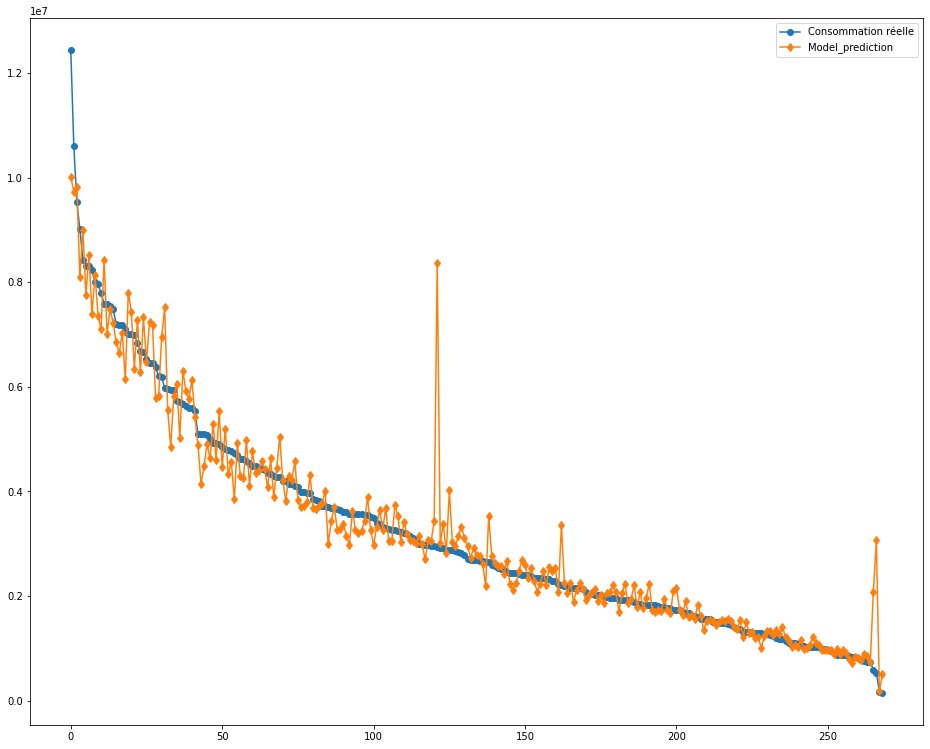

In [ ]:
fig = plt.figure(figsize=(16,13))
plt.plot(range(compare.shape[0]), compare['Consommation'], '-o' ,label='Consommation réelle')
plt.plot(range(compare.shape[0]), compare['Model_prediction'], '-d',label='Model_prediction')
plt.title('Données test gaz : Comparaison Actual vs Predict')
fig.savefig('gdrive/MyDrive/PFE_Models/Gaz Comparaison Actual vs Predict.png')
plt.legend()
plt.show();

In [ ]:
df_compare = x_test.join(compare, on=y_test.index).sort_values(by=['Consommation'], ascending=False)
df_compare

Code_Region  Mois  Taux Moyen Humidité  Temperature Moyenne (°C)  \
720            11     1                83.19                      1.75   
708            11     1                86.44                      5.30   
768            11     1                86.62                      4.37   
779            11    12                90.11                      6.72   
683            11    12                83.71                      5.48   
...           ...   ...                  ...                       ...   
367            24     8                64.24                     20.92   
782            11     3                65.69                      9.65   
559            44     4                68.44                     10.18   
1119           76     4                71.41                     11.78   
334            53     3                71.04                      9.84   

      Moyenne_Temperature max (12h)  Temperature du sol  PEG monthly price  \
720                            0.89                0.00             17.740   
708                            1.76               -0.03             16.330   
768                            1.50                0.00             20.493   
779                            2.08                0.00            115.224   
683                            1.92                0.08             28.110   
...                             ...                 ...                ...   
367                            6.48               15.57             20.880   
782                            3.31                0.00            127.367   
559                            3.55                4.71             92.917   
1119                           3.80                8.06             92.917   
334                            3.07                2.32            127.367   

      Consommation  Model_prediction  
720       12438587      1.002169e+07  
708       10613854      9.728965e+06  
768        9533929      9.821429e+06  
779        9013579      8.096390e+06  
683        8428953      9.004485e+06  
...            ...               ...  
367         735681      7.318648e+05  
782         592464      2.084214e+06  
559         523045      3.066004e+06  
1119        172404      1.758701e+05  
334         151946      5.096082e+05  

[269 rows x 9 columns]